# "Using Regression for Revenue Prediction of movies"
> "Using TMDb dataset we'll try to predict the revenue of a movie based on the characteristics of the movie, and predict whether a movie's revenue will exceed its budget or not"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/vignette/movies.png
- hide: false
- search_exclude: true

Throughout the case study/analysis we'll be using the following libraries:

| Library      | Purpose |
| ----------- | ----------- |
| `sklearn`      | Modelling       |
| `matplotlib`, `bokeh`   | Visualization        |
| `numpy`, `pandas` | Data Manipulation        |

In this case study I am going to do several things first, I want to **predict the revenue** of a movie based on the characteristics of the movie, second I want to **predict whether a movie's revenue will exceed its budget or not**.

# Drudgery: import and take a look at the data

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")
%matplotlib inline

df = pd.read_csv("data/processed_data.csv", index_col=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4775 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4391 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4716 non-null   object 
 15  status               

In [2]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


# Data Preprocessing
Our Second step would be to clean and transform the data so that we could apply Regression or Classification algorithm on the data.

## Defining Regression and Classification Outcomes
For regression we'll be using `revenue` as the target for outcomes, and for classification we'll construct an indicator of profitability for each movie. Let's define new column `profitable` such that:
$$
  \begin{equation}
    Profitabe =
    \begin{cases}
      1, & \text{if}\ revenue > budget \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}
$$

In [3]:
df['profitable'] = df.revenue > df.budget
df['profitable'] = df['profitable'].astype(int)

regression_target = 'revenue'
classification_target = 'profitable'

df['profitable'].value_counts()

1    2585
0    2218
Name: profitable, dtype: int64

2585 out of all movies in the dataset were profitable
## Handling missing and infinite values
Looking at the data we can easily guess that many of the columns are non-numeric and using a technique other than ommiting the columns might be a bit overhead. So I'm going to stick with plane and simple technique of ommiting the column with missing or infinite values.

1. Replace any `np.inf` or `-np.inf` occuring in the dataset with np.nan

In [4]:
df = df.replace([np.inf, -np.inf], np.nan)
print(df.shape)
df.info()

(4803, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4775 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4391 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4716 non-null   object 
 15  status    

2. Drop any column with `na`

In [5]:
df = df.dropna(how="any")
df.shape

(1406, 23)

## Transform `genre` column using `OneHotEncoding`

Since `genres` column consists of strings with comma separated genres e.g. `"Action, Adventure, Fantasy"` as a value for a particular movie, I'll convert string to list, then extract all unique genres in the list and finally add a column for each unique genre. Value of a specific genre will be `0` if it is present in `genres` otherwise `0`. 

In [6]:
list_genres = df.genres.apply(lambda x: x.split(","))
genres = []
for row in list_genres:
    row = [genre.strip() for genre in row]
    for genre in row:
        if genre not in genres:
            genres.append(genre)

for genre in genres:
    df[genre] = df['genres'].str.contains(genre).astype(int)

df[genres].head()

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,War,History,Music,Documentary,TV Movie,Foreign
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Extract numerical variables
Many of the variables in the dataset are already numerical which will be useful in regression, we'll be extracting these variables and we'll also calculate `skew` of the continuous variables, and `plot` these variables.

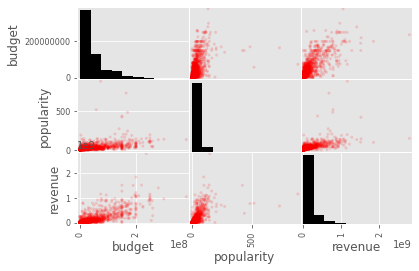

In [7]:
continuous_covariates = ['budget', 'popularity',
                         'runtime', 'vote_count', 'vote_average']
outcomes_and_continuous_covariates = continuous_covariates + \
    [regression_target, classification_target]
plotting_variables = ['budget', 'popularity', regression_target]
axes = pd.plotting.scatter_matrix(df[plotting_variables], alpha=0.15,
                                  color=(0, 0, 0), hist_kwds={"color": (0, 0, 0)}, facecolor=(1, 0, 0))

In [8]:
df[outcomes_and_continuous_covariates].skew()

budget          1.754872
popularity      7.968139
runtime         1.059804
vote_count      2.461041
vote_average   -1.080038
revenue         3.084680
profitable     -1.081030
dtype: float64

Since **"Linear algorithms love normally distributed data"**, and several of the variables `budget, popularity, runtime, vote_count, revenue` are right skewed. So now we'll remove skewness from these variables using `np.log10` to make it symmetric. But first we need to add very small positive number to all the columns as some of values are `0` and `log10(0) = -inf`.
{% include info.html text="We are not actually removing skewness from the data instead we're only appliying a non-linear transformation on the variables to make it symmetric. If you transform skewed data to make it symmetric, and then fit it to a symmetric distribution (e.g., the normal distribution) that is implicitly the same as just fitting the raw data to a skewed distribution in the first place." %}

In [9]:
for covariate in ['budget', 'popularity', 'runtime', 'vote_count', 'revenue']:
    df[covariate] = df[covariate].apply(lambda x: np.log10(1+x))
    
df[outcomes_and_continuous_covariates].skew()

budget         -2.816990
popularity     -0.431543
runtime         0.530489
vote_count     -0.677632
vote_average   -1.080038
revenue        -2.177372
profitable     -1.081030
dtype: float64

### Save this dataframe separately for modelling

In [10]:
df.to_csv("data/movies_clean.csv")

# Analysis
In this part we'd fit three models-`Linear Regression, Logistic Regression, and Random Forest`- to predict the value of `Revenue` and classify a movie as `profitable` or `non-profitable`. We'll be using the `movies_clean` data to fit these models.

In [11]:
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/movies_clean.csv')

In [12]:
# Define all covariates and outcomes from `df`.
regression_target = 'revenue'
classification_target = 'profitable'
all_covariates = ['budget', 'popularity', 'runtime', 'vote_count', 'vote_average', 'Action', 'Adventure', 'Fantasy', 
                  'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 
                  'Horror', 'Mystery', 'War', 'History', 'Music', 'Documentary', 'TV Movie', 'Foreign']

regression_outcome = df[regression_target]
classification_outcome = df[classification_target]
covariates = df[all_covariates]

# Instantiate all regression models and classifiers.
linear_regression = LinearRegression()
logistic_regression = LogisticRegression()
forest_regression = RandomForestRegressor(max_depth=4, random_state=0)
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)

### Function that computes the score of models

In [13]:
def correlation(estimator, X, y):
    estimator.fit(X,y)
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)

def accuracy(estimator, X, y):
    estimator.fit(X,y)
    y_pred = estimator.predict(X)
    return accuracy_score(y, y_pred)

# Validation
`accuracy_score` and `correlation` gives fairly good estimate of how well the model was fit using the training data but in general the task of a Data Scientist or ML Engineer is to come up with a model that performs well on the previously unseen data rather than the data that was used for training the model. `Cross-Validation` is often used as a solution for this problem. It's an accuracy metric of an estimator, it also lets us check for over-fitting of the model. There are several techniques for cross-validation, some of which are as follows:
1. `k-fold cross val`
2. `stratified k-fold cross val`
3. `LOOCV` - Leave one out cross val

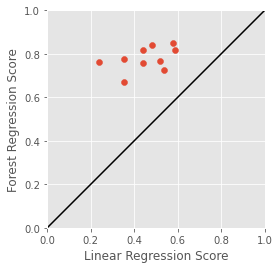

In [14]:
from sklearn.model_selection import cross_val_score
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)

plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")

plt.show()

Validation scores speaks for themselves, `Random Forest` is clearly the better algorithm for predicting the `revenue` of in general for regression. But the catch is, both of the algorithm performed very poorly on the dataset. Let's once again inspect the data and try to find some inconsistency in it.

In [15]:
df.revenue.describe()

count    1406.000000
mean        6.993585
std         2.509281
min         0.000000
25%         7.158814
50%         7.842995
75%         8.304477
max         9.445287
Name: revenue, dtype: float64

In [16]:
# count the movies with zero revenue
sum(df.revenue == 0.0)

146

OK! so we might have just found out the cause of the problem, **Zero Revenue Movies**. Probably, the algorithm is having a hard time predicting the `zero-revenue`. Let's now remove these movies from the dataset and then try to compute the validation score and see if the accuracy improves.

In [17]:
positive_revenue_df = df.loc[df.revenue != 0.0]
positive_revenue_df.revenue.describe()

count    1260.000000
mean        7.803953
std         0.835207
min         1.672098
25%         7.484363
50%         7.946541
75%         8.341485
max         9.445287
Name: revenue, dtype: float64

In [18]:
regression_outcome = positive_revenue_df[regression_target]
classification_outcome = positive_revenue_df[classification_target]
covariates = positive_revenue_df[all_covariates]

# Reinstantiate all regression models and classifiers.
linear_regression = LinearRegression()
logistic_regression = LogisticRegression()
forest_regression = RandomForestRegressor(max_depth=4, random_state=0)
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

In [19]:
np.mean(forest_regression_scores)

0.7680846546233253

In [20]:
np.mean(linear_regression_scores)

0.5780431611495556

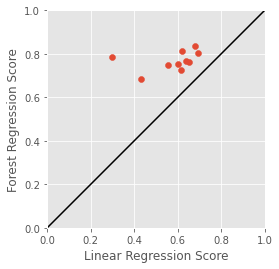

('budget', 0.30757299732366344)
('popularity', 0.08355296569387499)
('runtime', 0.016135965006071725)
('vote_count', 0.5759260530517182)
('vote_average', 0.006646714634639984)
('Action', 0.00039731194014744624)
('Adventure', 0.003080303040107078)
('Fantasy', 0.0)
('Science Fiction', 0.0009980285384426231)
('Crime', 0.0010130985717443698)
('Drama', 0.0013281289930065158)
('Thriller', 0.00015821728190237307)
('Animation', 0.0009318004228486637)
('Family', 0.0004586994511166151)
('Western', 0.00015626864826347376)
('Comedy', 0.0005068269265224419)
('Romance', 6.604583330721586e-05)
('Horror', 0.00020010584158045155)
('Mystery', 0.00018214788588276072)
('War', 0.00021568794173586987)
('History', 0.0004223908705396497)
('Music', 0.0)
('Documentary', 5.0242102884089965e-05)
('TV Movie', 0.0)
('Foreign', 0.0)


In [21]:
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)

plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")

plt.show()

forest_regression.fit(positive_revenue_df[all_covariates], regression_outcome)
for row in zip(all_covariates, forest_regression.feature_importances_,):
    print(row)

3 most important variables for predicting revenue in the random forest model were: `budget`, `runtime`, and `vote_count`

In the final step let's do compute and plot the cross-validation scores for *Classification*

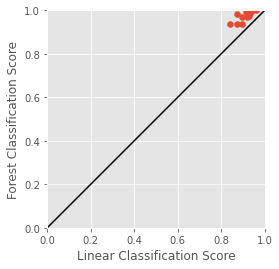

('budget', 0.08765680648089587)
('popularity', 0.2811360280003983)
('runtime', 0.04154729351420867)
('vote_count', 0.36967661830845444)
('vote_average', 0.10261105225795153)
('Action', 0.0073412694021133835)
('Adventure', 0.007596959755592538)
('Fantasy', 0.0051937079152913745)
('Science Fiction', 0.010816587516514861)
('Crime', 0.006772395781754328)
('Drama', 0.023093574562804687)
('Thriller', 0.0035569898966812397)
('Animation', 0.0019388197444951466)
('Family', 0.0066609392542522055)
('Western', 0.005480591973153852)
('Comedy', 0.0022574689899296065)
('Romance', 0.0031608732977368944)
('Horror', 0.001715202327676785)
('Mystery', 0.004282452349394276)
('War', 0.011275947022575308)
('History', 0.006793172805113654)
('Music', 0.004308655018573079)
('Documentary', 0.002846458591904433)
('TV Movie', 0.0)
('Foreign', 0.0022801352325337114)


In [22]:
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

plt.show();

forest_classifier.fit(positive_revenue_df[all_covariates], classification_outcome)
for row in zip(all_covariates, forest_classifier.feature_importances_,):
    print(row)